# Assorted Spreading Code...

Stuff here to teset, etc...

In [36]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Fay Spreading...

Fay spreading, as done in ADIOS2 (and Merv's book)


## Initial area

$A_0 = \pi \frac{K_1^4}{K_2^2}\left( \frac{g V_0^5 \Delta}{\nu_w^2} \right)^{1/6}$

## Initial radius

$r_0 = \frac{K_1^2}{K_2}\left( \frac{g V_0^5 \Delta}{\nu_w^2} \right)^{1/12}$

This is the end of the gravity-viscous stage -- essentially linear with initial volume

### Continuous release?
But what to do about a continuos release? We should be able to do something with the the release rate -- scaling to the time to get to the end of the gravity-viscous stage? The idea here is that the shorter the timestep, the smaller each LE mass is -- but we dont want the result to be a function of timestep.

In [37]:
# Constants
K1=1.53 # not sure where these come from -- slightly different than Fay (1971)
K2=1.21

visc_w = 1e-6 # viscoscity of water: m^2/s

g = 9.806 # gavity, m/s^2

def delta():
    rho_oil = 0.8 # density of oil
    rho_water = 1 # density of water
    return (rho_water-rho_oil)/rho_water

def init_area(V0):
    return np.pi * (K1**4/K2**2) * ((g * V0**5 * delta())/visc_w**2 )**(1./6.) 

def init_radius(V0):
    return         (K1**2/K2) * ((g * V0**5 * delta())/visc_w**2 )**(1./12.)

def old_init_area(V0):
    return np.pi*(K2**4/K1**2)*((V0**5*g*delta())/(visc_w**2))**(1./6.)


In [38]:
vol = np.linspace(1,100) # 1 to 100 cubic meters
area = init_area(vol)
old_area = old_init_area(vol)
radius = init_radius(vol)

[ 0.54390769  0.45164263  0.40277741  0.36826818  0.3412104   0.31878132
  0.29953158  0.28261209  0.26748015  0.25376655  0.24120815  0.22961034
  0.21882497  0.20873648  0.19925288  0.19029971  0.18181578  0.17375017
  0.16606003  0.15870892  0.15166561  0.14490309  0.13839786  0.13212931
  0.1260793   0.12023173  0.11457228  0.10908811  0.10376772  0.09860071
  0.09357769  0.0886901   0.08393018  0.07929079  0.07476543  0.0703481
  0.06603329  0.06181591  0.05769125  0.05365492  0.04970289  0.04583136
  0.04203681  0.03831597  0.03466574  0.03108325  0.02756579  0.02411082
  0.02071594  0.01737891]


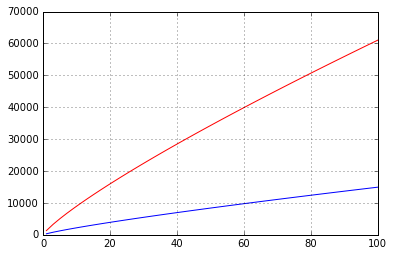

In [39]:
fig, ax = plt.subplots(1,1)
ax.plot(vol, area, c='r')
# ax.plot(vol, np.pi * radius**2)
ax.plot(vol, old_area, c='b')
# ax.plot(vol, 600* vol)
# ax.plot(vol, area - 600*vol)
ax.grid(True)
print((area - 600*vol)/area)


In [40]:
# A check on the radius / area code:
assert np.allclose(np.pi * radius**2, area)

## Gravity-viscous spreading

The main "Fay Spreading"

radius:

$r(t) = K_2(\frac{g \Delta V_0^2 t^{3/2}}{\nu^{1/2}})^{1/6}$

area:

$A(t) = \pi K_2^2 (\frac{g \Delta V_0^2 t^{3/2}}{\nu^{1/2}})^{1/3}$

or

$A(t) = \pi K_2^2 (\frac{g \Delta V_0^2}{\nu^{1/2}})^{1/3} \sqrt(t)$



In [41]:
def Fay(V0, t):
    return np.pi * k2**2 * (delta() * g * V0**2/np.sqrt(visc_w))**(1./3) * np.sqrt(t)

In [42]:
V0 = 100 # cubic meters ~ 16kgal
time = np.linspace(1, 24*3600)
fay_area = Fay(V0, time)

NameError: global name 'k2' is not defined

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(time / 3600, fay_area)
#ax.hold(True)
ax.hlines(init_area(V0), time[0]/3600, time[-1]/3600)
ax.annotate('initial area', (24, init_area(V0) ))
ax.legend(('Fay',))

ax.set_xlabel('time ($hrs$)')
ax.set_ylabel('area ($m^3$)')

## Richardson's 4/3 Diffusion

In [ ]:
#The code:

class Diffusion(object):

    alpha = 0.01 # should be between 0.002 and 0.01 all in CGS units
                 # this is the larger number -- probably reasonably suited to coastal surface flows. 
    
    def var(self, t):
        """ the variance as a function of time, according to the 4/3 law"""
        return (2.0/3.0 * self.alpha * t)**3

    def area(self, t):
        return np.pi * 4.0 * self.var(t)
        
    def sigma(self, t):
        return np.sqrt(self.var(t))
    
    def Diff(self, t):
        """The Diffusion coef as a function of time"""
        return 4.0/9.0 * self.alpha**3 * t**2
    
    def time(self, D):
        """time as a function of Diffusion coef"""
        return 3.0 * 2.0 * np.sqrt(D / self.alpha**3)
    
    def Length(self, D):
        """comutes the mixing length scale"""
        return D  / self.alpha

diff = Diffusion()
diff_area = diff.area(time)

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(time / 3600, fay_area,label='Fay')
ax.plot(time / 3600, diff_area, label='Diff')

ax.hlines(init_area(V0), time[0]/3600, time[-1]/3600)

ax.annotate('initial area', (24, init_area(V0) ))
ax.legend()